In [ ]:
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = lambda x: '%.4f' % x

# **Load Data**

In [ ]:
version_str = "_v3"
input_dir = "drive/My Drive/MMAI869/data/"
gen_dir = 'gen_v3/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
visits = pd.read_csv(input_dir+"visits"+version_str+".csv")
locations = pd.read_csv(input_dir+"locations"+version_str+".csv", encoding = "ISO-8859-1")
visits_items = pd.read_csv(input_dir+"visit_items"+version_str+".csv", encoding = "ISO-8859-1")
films = pd.read_csv(input_dir+"films"+version_str+".csv", encoding = "ISO-8859-1")
experience_type = pd.read_csv(input_dir+"experience_type"+version_str+".csv", encoding = "ISO-8859-1")
sales_channels = pd.read_csv(input_dir+"sales_channels"+version_str+".csv", encoding = "ISO-8859-1")
timeslice = pd.read_csv(input_dir+"timeslice"+version_str+".csv", encoding = "ISO-8859-1")
visits_items = pd.read_csv(input_dir+"visit_items"+version_str+".csv", encoding = "ISO-8859-1")

#Custom_files
items = pd.read_csv(input_dir+"mapping_concession_flags"+version_str+".csv")
items.fillna(0, inplace=True)

In [ ]:
visits.head()

,Visit_ID,CINEPLEX_D_Membership_ID,Visit_Date,Visit_TimeSlice_ID,Location_ID,Auditorium_Experience_ID,Film_ID,Seating_Experience_ID,Sales_Channel_ID,Performance_Experience_ID,Performance_Type_ID,Spend,Revenue,Points_Earned,Points_Redeemed,Discount,Has_US_Is_LrgPopcorn,Has_US_Is_Butter,Has_US_Is_Alcohol,Has_US_Is_Candy,Has_US_Is_Coffee,Has_US_Is_Kiddietray,Has_US_Is_Voucher,Has_US_Is_MenuFood
0,2,23777,2019-01-01,15,7253,1,28757,1,8,1,1,15.0400,15.0400,100,0,1.6800,0,0,0,0,0,0,0,0
1,3,60723,2019-01-01,15,7123,0,0,0,8,0,0,29.6100,29.6100,297,0,3.2900,0,1,0,0,0,0,1,1
2,4,61080,2019-01-01,15,7290,2,24899,2,8,2,1,28.4000,28.4000,235,0,3.1600,1,1,0,0,0,0,0,0
3,5,103538,2019-01-01,14,1142,1,24977,1,2,1,1,0.0000,10.0000,0,1000,0.0000,0,0,0,0,0,0,0,0
4,6,120196,2019-01-01,23,9181,1,29694,1,2,1,1,17.6100,17.6100,100,0,1.9500,0,0,0,0,0,0,0,0


# **Data Wrangling and Cleaning**
- Merge all the fact tables (e.g., `films`, `locations`) into on big `visits` table - this table will act as the "historical truth"
- Fill in missing values with "Unknown"
- Extract some date info


In [ ]:
def calc_popcorn_item(df):
    # TALK TO MOHAMMAD to REVIEW THIS VS. HIS GROUPING
    bool_popcorn_and_not_topping = ((items['EIS_Sub_Group_Description']!='TOPPING') & 
                                       (items['Item_Class_Description1']=='VHO-POPCORN'))
    
    #These categories are coupons/vouchers that have popcorn purchase but no butter (VHO-COMBO CIP is an exception)
    other_popcorn_categories = ['VHO-COMBO NON CIP','COUPONS','ATM-Conc-Voucher']
    bool_other_popcorn_categories = (items['Item_Class_Description1'].isin(other_popcorn_categories))
    popcorn_flag = np.where(((bool_popcorn_and_not_topping) | (bool_other_popcorn_categories)),1,0)
    return popcorn_flag

#Data Cleaning
def clean_timeslice(df):
    drop_columns = ['Visit_TimeSlice_ID','TimeSlice_ID','TimeSlice_Start_Time','TimeSlice_End_Time',
                    'TimeSlice_Hour_12','TimeSlice_Hour_24']
    df['TimeSlice_Hour_AMPM'] = np.where(df['TimeSlice_Hour_24']>=12,'PM','AM')
    df.drop(drop_columns, axis=1, inplace=True)
    return df

def clean_sales_channel(df):
    mapping_sales_channel = pd.read_csv(input_dir+"mapping_sales_channel"+version_str+".csv", encoding = "ISO-8859-1")
    df = pd.merge(df, mapping_sales_channel, on = ['Sales_Channel_ID','Sales_Channel'], how='left')
    return df


data.groupby('partner_id').agg('count_varia', lamda value:((year_month-year_month_b6m)<6) )

# Feature Engineering
def member_level_visit_stats(df,column):
    df = df[df[column]==0].groupby('CINEPLEX_D_Membership_ID').agg(
        {
         'Revenue': ['min', 'mean', 'max', 'sum'],
         'Spend':['min', 'mean', 'max', 'sum'],
         'Discount':['min', 'mean', 'max', 'sum'],
         'Points_Earned':['min', 'mean', 'max', 'sum'],
         'Points_Redeemed':['min', 'mean', 'max', 'sum']
        })
    df.columns = [(column+"_"+"_".join(x)) for x in df.columns.ravel()]
    df = df.reset_index()
    df.rename(columns={'CINEPLEX_D_Membership_ID_': "CINEPLEX_D_Membership_ID"},inplace=True)
    df = df.fillna(0)
    return df

def ticket_sale_count(df,df_items):
    df_items = pd.merge(df_items[['Visit_ID','CINEPLEX_D_Membership_ID','Item_Class_Description1']],
                        df[['Visit_ID','CINEPLEX_D_Membership_ID','Film_ID']],how='left',on=['Visit_ID','CINEPLEX_D_Membership_ID'])
    df_items['Tickets'] = np.where((df_items['Item_Class_Description1']=='0') & (df_items['Film_ID']!=0),1,0)
    return df_items['Tickets']


# Item Purchase List - Clean-up

In [ ]:
# categorize all the butter items (when the Popcorn description = VHO-POPCORN)
items['YM_popcorn'] = calc_popcorn_item(items)

# List of all Butter Items in the Item inventory
items[(items['CINEPLEX_Item_Description'].str.contains('BUTTER'))]

,CINEPLEX_Item_ID,CINEPLEX_Item_Description,CINEPLEX_Item_Status,EIS_Group_Description,EIS_Sub_Group_Description,Item_Report_Code2,Item_Report_Code3,Item_Class_Description1,Item_Class_Description2,Item_Class_Description3,Is_Item_Package,Is_Box_Office_Item,YM_BUTTER,YM_Alcohol,YM_Coffee,YM_popcorn,YM_concession,YM_Voucher,YM_Coupon,YM_VoucherCoupon
166,93852,VHO CORN - BUTTER - KID,A,Popcorn,TOPPING,0,0,VHO-POPCORN,0,0,0,0,1,0,0,0,1,0,0,0
167,93853,VHO CORN - BUTTER - LARGE,A,Popcorn,TOPPING,Add 60-320 Cals,Y,VHO-POPCORN,0,0,0,0,1,0,0,0,1,0,0,0
168,81015,VHO CORN - BUTTER - LAYERED - LARGE,A,Food,Food,Add 120-640 Cals,Y,VHO-POPCORN,0,0,0,0,1,0,0,1,1,0,0,0
169,81048,VHO CORN - BUTTER - LAYERED REGULAR,A,Food,Food,Add 120-640 Cals,Y,VHO-POPCORN,0,0,0,0,1,0,0,1,1,0,0,0
170,81049,VHO CORN - BUTTER - LAYERED SMALL,A,Food,Food,Add 120-640 Cals,Y,VHO-POPCORN,0,0,0,0,1,0,0,1,1,0,0,0
171,93854,VHO CORN - BUTTER - REGULAR,A,Popcorn,TOPPING,Add 60-320 Cals,0,VHO-POPCORN,0,0,0,0,1,0,0,0,1,0,0,0
172,93855,VHO CORN - BUTTER - SMALL,A,Popcorn,TOPPING,Add 60-320 Cals,0,VHO-POPCORN,0,0,0,0,1,0,0,0,1,0,0,0
259,80590,VHO LQ DESS - SALTED BUTTERSCOTCH BROWNIE,A,0,0,(VG) 550 Cals,0,VHO-LICENSED FOOD,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Read in visit item file (list of purchases)

visits_items.shape
visits_items = pd.merge(visits_items, items, on='CINEPLEX_Item_ID', how='left')
visits_items['Ticket'] = ticket_sale_count(visits, visits_items)
visits_items['Ticket'].fillna(0,inplace=True)
visits_items.shape

(170060, 8)

(170060, 28)

In [ ]:
# Sample Check
visits_items[visits_items.Visit_ID == 122][['CINEPLEX_Item_Description','YM_BUTTER']]

,CINEPLEX_Item_Description,YM_BUTTER
65826,<Unknown>,0
65903,VHO CORN - POPCORN REGULAR 130oz.,0
65904,VHO DRINK - CUP REGULAR 24 OZ FOUNTAIN,0
65905,VHO CORN - BUTTER - REGULAR,1
65906,VHO CORN - BUTTER - REGULAR,1


# Visit Items

In [ ]:
#Member Level Stats
visit_items_summary = visits_items.groupby(['Visit_ID','CINEPLEX_D_Membership_ID']).agg(
{
    'YM_BUTTER': ['max'],
})

# Pandas group-by creates a MultiIndex, which we don't want. The following few lines
# will rename the columns of the dataframe to something more reasonbale.
visit_items_summary.columns = ["_".join(x) for x in visit_items_summary.columns.ravel()]
visit_items_summary = visit_items_summary.rename(columns={'CINEPLEX_D_Membership_ID_': "CINEPLEX_D_Membership_ID"})
visit_items_summary.head()

,,YM_BUTTER_max
Visit_ID,CINEPLEX_D_Membership_ID,
2,23777,0
3,60723,1
4,61080,1
5,103538,0
6,120196,0


# **Merge all the data**

In [ ]:
visits.shape

visits = pd.merge(visits,visit_items_summary[['YM_BUTTER_max']],on=['Visit_ID','CINEPLEX_D_Membership_ID'], how='left')
visits = visits.merge(films, how="left", on="Film_ID")
visits = visits.merge(experience_type, how="left")
visits = visits.merge(sales_channels, how="left")
visits = visits.merge(timeslice, left_on="Visit_TimeSlice_ID", right_on="TimeSlice_ID", how="left")
visits = visits.merge(locations, how="left")
visits.shape

(36258, 24)

(36258, 61)

In [ ]:
visits = clean_timeslice(visits)
visits = clean_sales_channel(visits)

In [ ]:
# Fill in empty values on language
visits['Market_Language'] = visits['Market_Language'].fillna('Unknown')

In [ ]:
# Extract some info about the date
visits['Visit_Date'] = pd.to_datetime(visits['Visit_Date'])
visits['Visit_Date_DOW'] = visits['Visit_Date'].dt.day_name()
visits['Visit_Date_Week'] = visits['Visit_Date'].dt.strftime('%U')
visits['Visit_Date_Month'] = visits['Visit_Date'].dt.month_name()
visits['Visit_Date_IsWeekend'] = np.where(visits['Visit_Date'].dt.weekday < 5, 0, 1)



In [ ]:
visits.head()
visits.shape

,Visit_ID,CINEPLEX_D_Membership_ID,Visit_Date,Location_ID,Auditorium_Experience_ID,Film_ID,Seating_Experience_ID,Sales_Channel_ID,Performance_Experience_ID,Performance_Type_ID,Spend,Revenue,Points_Earned,Points_Redeemed,Discount,Has_US_Is_LrgPopcorn,Has_US_Is_Butter,Has_US_Is_Alcohol,Has_US_Is_Candy,Has_US_Is_Coffee,Has_US_Is_Kiddietray,Has_US_Is_Voucher,Has_US_Is_MenuFood,YM_BUTTER_max,Film_Title,Title_ID,Title_Name,Theatrical_Release_Date,Film_Runtime,Language,Market_Language,Release_Pattern,Performance_Type,Is_IMAX,Is_DBOX_Capable,Release_Status,Media_Class_Description,Is_4Dx,Genre_Hierarchy_1,Auditorium_Experience_Description,Is_Premium,Sales_Channel,TimeSlice_Description,Location_Name,Location_Short_Name,Location_Interactive_Name,Address1,City,Province_CD,Postal_Code,Country_CD,Is_VIP,Is_Outtakes,Is_Licensed_Bar,Is_Licensed_Lounge,TimeSlice_Hour_AMPM,Sales_Channel_Breakdown,Sales_Channel_Online,Visit_Date_DOW,Visit_Date_Week,Visit_Date_Month,Visit_Date_IsWeekend
0,2,23777,2019-01-01,7253,1,28757,1,8,1,1,15.0400,15.0400,100,0,1.6800,0,0,0,0,0,0,0,0,0,Vice,23956.0000,Vice,12/25/2018,133.0000,English,English,Wide,Film Presentation,0,0,A,Adult,0.0000,Drama,Regular,0,Point of Sale,1 - Early Matinee,CPX Eglinton T.C.,Warden&Eglin,Cineplex Odeon Eglinton Town Centre Cinemas,22 Lebovic Avenue,Toronto,ON,M1L 4V9,CA,0,1,1,0,PM,Sales_MainStore,0,Tuesday,00,January,0
1,3,60723,2019-01-01,7123,0,0,0,8,0,0,29.6100,29.6100,297,0,3.2900,0,1,0,0,0,0,1,1,1,<None>,0.0000,<None>,1/1/1900,0.0000,<None>,<None>,<None>,<None>,0,0,B,None,0.0000,Unknown,<Unknown>,0,Point of Sale,1 - Early Matinee,CPX Winston Churchill VIP,Winston Churchill,Cineplex Cinemas Winston Churchill & VIP,2081 Winston Park Dr.,Oakville,ON,L6H 6P5,CA,1,1,1,0,PM,Sales_MainStore,0,Tuesday,00,January,0
2,4,61080,2019-01-01,7290,2,24899,2,8,2,1,28.4000,28.4000,235,0,3.1600,1,1,0,0,0,0,0,0,1,Aquaman,22133.0000,Aquaman,12/21/2018,143.0000,English,English,Wide,Film Presentation,0,1,A,Adult,0.0000,Adaptation,AVX,1,Point of Sale,1 - Early Matinee,CPX Hamilton Mountain,CPX Hamilton,Cineplex Cinemas Hamilton Mountain,795 Paramount Drive,Stoney Creek,ON,L8J 0B4,CA,0,1,1,0,PM,Sales_MainStore,0,Tuesday,00,January,0
3,5,103538,2019-01-01,1142,1,24977,1,2,1,1,0.0000,10.0000,0,1000,0.0000,0,0,0,0,0,0,0,0,0,Mary Poppins Returns,22187.0000,Mary Poppins Returns,12/19/2018,131.0000,English,English,Wide,Film Presentation,0,1,A,Family,0.0000,Comedy,Regular,0,Kiosk,1 - Early Matinee,CPX Pitt Meadows,Meadowtown,Cineplex Odeon Meadowtown Cinemas,"#410, 19800 Lougheed Highway",Pitt Meadows,BC,V3Y 2W1,CA,0,1,0,0,PM,Sales_MainKiosk,0,Tuesday,00,January,0
4,6,120196,2019-01-01,9181,1,29694,1,2,1,1,17.6100,17.6100,100,0,1.9500,0,0,0,0,0,0,0,0,0,DeuxiÂme acte,23976.0000,Second Act,12/21/2018,104.0000,French,French,Wide,Film Presentation,0,0,A,Adult,0.0000,Comedy,Regular,0,Kiosk,2 - Late Matinee,CPX Beauport,Beauport,CinÂma Cineplex Odeon Beauport,825 rue ClÂmenceau,Beauport,QC,G1C 2K6,CA,0,0,0,0,PM,Sales_MainKiosk,0,Tuesday,00,January,0


(36258, 62)

In [ ]:
# Need to remove everything we know about this visit

# `df` will act as the main training data. 
# Think of `df` as "what will be available during prediction time" and `visits` as `historical information from which we can engineer
# features. 
# This `df` will be the same as visits, except with columsn removed that either (a) would not be available
X = visits.copy()

remove_cols = [

            # Can't have these (won't be available in future)
           'Visit_Date','Film_ID','Spend', 'Revenue', 'Points_Earned', 'Points_Redeemed', 'Discount',
           'Has_US_Is_LrgPopcorn', 'Has_US_Is_Butter', 'Has_US_Is_Alcohol', 'Has_US_Is_Candy',
           'Has_US_Is_Coffee', 'Has_US_Is_Kiddietray', 'Has_US_Is_Voucher', 'Has_US_Is_MenuFood',
            'Spend','Discount','Revenue','Points_Earned','Points_Redeemed','YM_BUTTER_max',
    
            # Don't want these (won't be helpful, I don't think.)
    
           'Film_Title', 'Title_Name', 'Theatrical_Release_Date', 'Release_Status', 'Release_Pattern', 'Title_ID', 
           'Location_Name', 'Location_Short_Name', 'Location_Interactive_Name',
           'Address1', 'Postal_Code','Country_CD','City',
          ]  

X = X.drop(remove_cols, axis=1)

In [ ]:
X['Is_IMAX'] = X['Is_IMAX'].astype('int')
X['Is_DBOX_Capable'] = X['Is_DBOX_Capable'].astype('int')
X['Visit_Date_Week'] = X['Visit_Date_Week'].astype('int')
X.head()
X.shape

,Visit_ID,CINEPLEX_D_Membership_ID,Location_ID,Auditorium_Experience_ID,Seating_Experience_ID,Sales_Channel_ID,Performance_Experience_ID,Performance_Type_ID,Film_Runtime,Language,Market_Language,Performance_Type,Is_IMAX,Is_DBOX_Capable,Media_Class_Description,Is_4Dx,Genre_Hierarchy_1,Auditorium_Experience_Description,Is_Premium,Sales_Channel,TimeSlice_Description,Province_CD,Is_VIP,Is_Outtakes,Is_Licensed_Bar,Is_Licensed_Lounge,TimeSlice_Hour_AMPM,Sales_Channel_Breakdown,Sales_Channel_Online,Visit_Date_DOW,Visit_Date_Week,Visit_Date_Month,Visit_Date_IsWeekend
0,2,23777,7253,1,1,8,1,1,133.0000,English,English,Film Presentation,0,0,Adult,0.0000,Drama,Regular,0,Point of Sale,1 - Early Matinee,ON,0,1,1,0,PM,Sales_MainStore,0,Tuesday,0,January,0
1,3,60723,7123,0,0,8,0,0,0.0000,<None>,<None>,<None>,0,0,None,0.0000,Unknown,<Unknown>,0,Point of Sale,1 - Early Matinee,ON,1,1,1,0,PM,Sales_MainStore,0,Tuesday,0,January,0
2,4,61080,7290,2,2,8,2,1,143.0000,English,English,Film Presentation,0,1,Adult,0.0000,Adaptation,AVX,1,Point of Sale,1 - Early Matinee,ON,0,1,1,0,PM,Sales_MainStore,0,Tuesday,0,January,0
3,5,103538,1142,1,1,2,1,1,131.0000,English,English,Film Presentation,0,1,Family,0.0000,Comedy,Regular,0,Kiosk,1 - Early Matinee,BC,0,1,0,0,PM,Sales_MainKiosk,0,Tuesday,0,January,0
4,6,120196,9181,1,1,2,1,1,104.0000,French,French,Film Presentation,0,0,Adult,0.0000,Comedy,Regular,0,Kiosk,2 - Late Matinee,QC,0,0,0,0,PM,Sales_MainKiosk,0,Tuesday,0,January,0


(36258, 33)

# **Training/Test Split**

In [ ]:
# The name of the column in visits that has the target value we want to predict
# Change this to whatever you need/want!
target_col = 'YM_BUTTER_max'

y = visits[target_col]

train_index = X['Visit_ID'] <= 88863
test_index = ~train_index

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

X_train.shape
y_train.shape

X_test.shape
y_test.shape

(31079, 33)

(31079,)

(5179, 33)

(5179,)

In [ ]:
X_train.head()

,Visit_ID,CINEPLEX_D_Membership_ID,Location_ID,Auditorium_Experience_ID,Seating_Experience_ID,Sales_Channel_ID,Performance_Experience_ID,Performance_Type_ID,Film_Runtime,Language,Market_Language,Performance_Type,Is_IMAX,Is_DBOX_Capable,Media_Class_Description,Is_4Dx,Genre_Hierarchy_1,Auditorium_Experience_Description,Is_Premium,Sales_Channel,TimeSlice_Description,Province_CD,Is_VIP,Is_Outtakes,Is_Licensed_Bar,Is_Licensed_Lounge,TimeSlice_Hour_AMPM,Sales_Channel_Breakdown,Sales_Channel_Online,Visit_Date_DOW,Visit_Date_Week,Visit_Date_Month,Visit_Date_IsWeekend
0,2,23777,7253,1,1,8,1,1,133.0000,English,English,Film Presentation,0,0,Adult,0.0000,Drama,Regular,0,Point of Sale,1 - Early Matinee,ON,0,1,1,0,PM,Sales_MainStore,0,Tuesday,0,January,0
1,3,60723,7123,0,0,8,0,0,0.0000,<None>,<None>,<None>,0,0,None,0.0000,Unknown,<Unknown>,0,Point of Sale,1 - Early Matinee,ON,1,1,1,0,PM,Sales_MainStore,0,Tuesday,0,January,0
2,4,61080,7290,2,2,8,2,1,143.0000,English,English,Film Presentation,0,1,Adult,0.0000,Adaptation,AVX,1,Point of Sale,1 - Early Matinee,ON,0,1,1,0,PM,Sales_MainStore,0,Tuesday,0,January,0
3,5,103538,1142,1,1,2,1,1,131.0000,English,English,Film Presentation,0,1,Family,0.0000,Comedy,Regular,0,Kiosk,1 - Early Matinee,BC,0,1,0,0,PM,Sales_MainKiosk,0,Tuesday,0,January,0
4,6,120196,9181,1,1,2,1,1,104.0000,French,French,Film Presentation,0,0,Adult,0.0000,Comedy,Regular,0,Kiosk,2 - Late Matinee,QC,0,0,0,0,PM,Sales_MainKiosk,0,Tuesday,0,January,0


# **Feature Engineering (On the Training Data Only)**
We need to take special care avoid data leakage. In particular, when we are engineering features that involves calculations of the data, those calculations should be trained (fit) from the training data.


# **Per-Member Aggregate Features**

We now calcualte member-level aggregation statistics, such as:
 - The number of total visits
 - The number of differnet locations the member has visited
 - The number of times a member has purchased large popcorn
 - The number of times a member has purchased butter
 - etc.

In [ ]:
visits_items.head(5)
visits_items.shape

NameError: ignored

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler


class MyTransformer():
    
    def __init__(self, visits_df, visits_items_df):
        self.visits_df = visits_df
        self.visits_items_df = visits_items_df
        self.visit_member_map = visits_df[['Visit_ID', 'CINEPLEX_D_Membership_ID' ]]
        
    # The fit method is where we will compute the aggregate features for each member, and save the results
    # for later (i.e., transform)
    def fit(self, X, y=None):
        # First, fit the OneHotEncoder and save for later.

        self.visits_df = pd.merge(self.visits_df,self.visits_items_df,how='left',on=['Visit_ID','CINEPLEX_D_Membership_ID'])
        
        
        self.cat_attrs = X.select_dtypes(include=[np.object]).columns
        self.OHE = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False)
        self.OHE.fit(X[self.cat_attrs])
        self.cat_feature_names = list(self.OHE.get_feature_names(self.cat_attrs))
        
        # Now, compute the member-level aggregation statistics.
        # Limit the visits to just the members in this training data that's being fit to.
        # Otherwise, there will be data leakage!
        self.visits_df =  self.visits_df[self.visits_df['Visit_ID'].isin(X['Visit_ID'])]
        
        # Define my own version of the 'mode' function, which will just return the first mode (in case of tie) and 
        # thus avoid an annoying error from groupby (whcih always wants just one value)
        my_mode = lambda x: pd.Series.mode(x)[0]
        
        # Use a simple group by to compute some aggregrate statistics. We can do anything we want here,
        # this is just an example!
        members_visits = self.visits_df.groupby('CINEPLEX_D_Membership_ID').agg(
        {
        'Film_Runtime': ['mean', 'max'], #Clean-up for missing values
        'Is_VIP': ['mean', 'max'],
        }).reset_index()
        # Pandas group-by creates a MultiIndex, which we don't want. The following few lines
        # will rename the columns of the dataframe to something more reasonbale.
        members_visits.columns = ["_".join(x) for x in members_visits.columns.ravel()]
        members_visits = members_visits.rename(columns={'CINEPLEX_D_Membership_ID_': "CINEPLEX_D_Membership_ID"})
        members_visits.columns = members_visits.columns.str.replace("<lambda_0>", "mode")
        members_visits.columns = members_visits.columns.str.replace("<lambda>", "mode")
        # From Visits Table
        for col in ['YM_Alcohol','YM_Coffee','YM_popcorn','YM_concession','YM_Voucher','YM_Coupon','YM_VoucherCoupon','Ticket']:
            members_visits = pd.merge(members_visits, member_level_visit_stats(visits_items, col),how='left', on='CINEPLEX_D_Membership_ID')


        # We want to make sure we have all numeric data, so let's do OHE (dummies) to be sure.
        members_visits = members_visits.fillna(members_visits.mean())
    
        members_visits = pd.get_dummies(members_visits)
        # Save the results for later
        self.members_visits = members_visits
        # Save the names of the features for later
        self.memb_feature_names = list(self.members_visits.columns)
        return self
    
   
    def transform(self, X, y=None):
        # Get the OHE levels
        X_cat = pd.DataFrame(self.OHE.transform(X[self.cat_attrs]), columns=self.cat_feature_names)
        
        # Get the previously-computed member-level agg features.
        X_member_agg = pd.DataFrame(X["Visit_ID"])
        
        # Bring in the agg features for members that we previously computed (if available)
        X_member_agg = X_member_agg.merge(self.visit_member_map, how="inner", on="Visit_ID" )
        X_member_agg = X_member_agg.merge(self.members_visits, how="left", on="CINEPLEX_D_Membership_ID" )
            
        # For any members that didn't have agg features, then just fill them in with mean values.
        #--OLD X_member_agg = X_member_agg.fillna(X_member_agg.mean())
        X_member_agg = X_member_agg.fillna(0)
        X_member_agg = X_member_agg.drop(['Visit_ID'], axis=1)
        
        X.reset_index(drop=True, inplace=True)
        X_cat.reset_index(drop=True, inplace=True)
        X_member_agg.reset_index(drop=True, inplace=True)
        
        X_member_agg = X_member_agg.drop(['CINEPLEX_D_Membership_ID'], axis=1)
        
        X_transformed = pd.concat([X, X_cat, X_member_agg], axis=1, sort=False)
        X_transformed = X_transformed.drop(self.cat_attrs, axis=1)
        X_transformed = X_transformed.drop('Visit_ID', axis=1)
        return X_transformed


# **Build Model**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score, log_loss, confusion_matrix

def print_scores(clf,X_test,y_test):
    y_pred = clf.predict(X_test)

    # How did we do?
    print("F1 Score   = {:.3f}".format(f1_score(y_test, y_pred, average="macro")))
    print("Accuracy   = {:.3f}".format(accuracy_score(y_test, y_pred)))
    print("Kappa      = {:.3f}".format(cohen_kappa_score(y_test, y_pred)))
    print("Log Loss   = {:.3f}".format(log_loss(y_test, y_pred)))
    print("\nConfusion Matrix:")
    unique_label = np.unique([y_test, y_pred])
    cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=unique_label), 
    index=['true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label])
    print(cmtx)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred)) 

In [ ]:
Alfred_t = MyTransformer(visits,visits_items)
Alfred_t = Alfred_t.fit(X_train)
X_train_All = Alfred_t.transform(X_train)
X_test_All = Alfred_t.transform(X_test)

In [ ]:
X_train_All.shape

(31079, 297)

In [ ]:
Chosen_Features = ['Location_ID','Sales_Channel_ID','Film_Runtime','Visit_Date_Week','Sales_Channel_Breakdown_Sales_MainStore',
                   'YM_Alcohol_Revenue_mean','YM_Coffee_Revenue_min','YM_Coffee_Revenue_mean','YM_popcorn_Revenue_min',
                   'YM_popcorn_Revenue_mean','YM_popcorn_Points_Earned_mean','YM_concession_Revenue_mean','YM_concession_Spend_mean',
                  'YM_concession_Discount_mean', 'YM_concession_Points_Earned_sum','YM_Voucher_Revenue_min','YM_Voucher_Revenue_mean',
                  	'YM_Coupon_Revenue_mean',	'YM_VoucherCoupon_Revenue_min',	'YM_VoucherCoupon_Revenue_mean','YM_VoucherCoupon_Points_Earned_mean',
                  'Ticket_Revenue_min','Ticket_Revenue_mean','Ticket_Revenue_max','Ticket_Spend_min','Ticket_Discount_min' ]

In [ ]:
feature_columns = [X_train_All.columns.get_loc(c) for c in Chosen_Features]

In [ ]:
len(Chosen_Features)

26

# **Feature Selection**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
clf = RandomForestClassifier(class_weight='balanced')
rfecv = RFECV(estimator=clf, step=5, cv=StratifiedKFold(20), scoring='accuracy')
sel = rfecv.fit(X_train_All,y_train)
X_train_f = X_train_All.loc[:,sel.support_]
X_test_f = X_test_All.loc[:,sel.support_]

In [ ]:
X_train_f.shape

(31079, 152)

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', criterion='gini', random_state=42, n_estimators=200, max_depth=15)
rfecv_1 = RFECV(estimator=clf, step=10, cv=StratifiedKFold(20), scoring='accuracy')
sel_1 = rfecv_1.fit(X_train_f,y_train)
X_train_f_1 = X_train_f.loc[:,sel_1.support_]
X_test_f_1 = X_test_f.loc[:,sel_1.support_]

In [ ]:
X_train_f_1.head()

,Location_ID,Sales_Channel_ID,Film_Runtime,Visit_Date_Week,Sales_Channel_Point of Sale,Sales_Channel_Breakdown_Sales_MainStore,YM_Alcohol_Revenue_min,YM_Alcohol_Revenue_mean,YM_Coffee_Revenue_min,YM_Coffee_Revenue_mean,YM_Coffee_Points_Earned_mean,YM_popcorn_Revenue_min,YM_popcorn_Revenue_mean,YM_popcorn_Spend_mean,YM_popcorn_Points_Earned_mean,YM_concession_Revenue_mean,YM_concession_Spend_mean,YM_concession_Discount_mean,YM_concession_Points_Earned_sum,YM_Voucher_Revenue_min,YM_Voucher_Revenue_mean,YM_Coupon_Revenue_min,YM_Coupon_Revenue_mean,YM_VoucherCoupon_Revenue_min,YM_VoucherCoupon_Revenue_mean,YM_VoucherCoupon_Points_Earned_mean,Ticket_Revenue_min,Ticket_Spend_min,Ticket_Spend_mean,Ticket_Spend_max,Ticket_Discount_min,Ticket_Discount_mean
0,7253,8,133.0000,0,1.0000,1.0000,6.4900,8.4242,6.4900,8.4242,71.4167,7.5200,8.6000,8.6000,75.0000,8.6000,8.6000,0.9545,825.0000,6.4900,8.4242,6.4900,8.4242,6.4900,8.4242,71.4167,6.4900,6.4900,6.4900,6.4900,0.7200,0.7200
1,7123,8,0.0000,0,1.0000,1.0000,0.4900,6.3078,0.4900,6.3474,59.9265,0.5000,6.2870,5.5458,63.1404,10.5942,7.0733,0.7867,750.0000,0.4900,6.3474,0.4900,6.3128,0.4900,6.3128,59.5224,0.4900,0.4900,5.4373,16.1900,0.0500,0.6045
2,7290,8,143.0000,0,1.0000,1.0000,0.8000,5.4635,0.8000,5.4635,34.8846,0.8000,5.4339,4.0317,34.0870,6.7114,4.4079,0.4886,625.0000,0.8000,5.4635,0.8000,5.4635,0.8000,5.4635,34.8846,0.8000,0.8000,3.5493,7.4900,0.0900,0.3943
3,1142,2,131.0000,0,0.0000,0.0000,0.5000,6.1032,0.5000,6.1032,23.1818,0.5000,6.6671,2.9612,23.8235,9.1433,2.1433,0.2367,250.0000,0.5000,6.1032,0.5000,6.1032,0.5000,6.1032,23.1818,0.5000,0.5000,3.9985,7.1900,0.0600,0.4446
4,9181,2,104.0000,0,0.0000,0.0000,0.7800,7.8424,0.7800,7.8424,88.1905,0.7800,7.8424,7.8424,88.1905,8.0289,8.0289,0.8906,1650.0000,0.7800,7.8424,0.7800,7.8424,0.7800,7.8424,88.1905,0.7800,0.7800,4.3460,7.9900,0.0900,0.4860


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Feature: 0, Score: 0.05199
Feature: 1, Score: 0.03660
Feature: 2, Score: 0.10398
Feature: 3, Score: 0.12126
Feature: 4, Score: 0.01614
Feature: 5, Score: 0.01627
Feature: 6, Score: 0.00911
Feature: 7, Score: 0.03619
Feature: 8, Score: 0.01408
Feature: 9, Score: 0.04553
Feature: 10, Score: 0.02395
Feature: 11, Score: 0.02434
Feature: 12, Score: 0.06990
Feature: 13, Score: 0.02536
Feature: 14, Score: 0.02974
Feature: 15, Score: 0.03923
Feature: 16, Score: 0.02420
Feature: 17, Score: 0.02425
Feature: 18, Score: 0.02145
Feature: 19, Score: 0.01017
Feature: 20, Score: 0.03726
Feature: 21, Score: 0.00956
Feature: 22, Score: 0.03482
Feature: 23, Score: 0.00831
Feature: 24, Score: 0.03546
Feature: 25, Score: 0.02182
Feature: 26, Score: 0.00992
Feature: 27, Score: 0.01356
Feature: 28, Score: 0.02642
Feature: 29, Score: 0.02021
Feature: 30, Score: 0.01077
Feature: 31, Score: 0.02813


<BarContainer object of 32 artists>

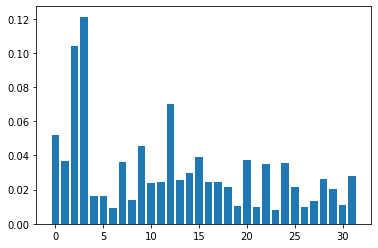

In [ ]:
# random forest for feature importance on a regression problem
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

model = RandomForestClassifier()
# fit the model
model.fit(X_train_f_1, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar(X_train_f_1.columns, importance)
pyplot.show()

In [ ]:
importance[sorted_idx][21:]
X_train_f_1.columns[sorted_idx][21:]


array([0.03482383, 0.03545659, 0.03618733, 0.03659841, 0.03726436,
       0.03923369, 0.04552888, 0.0519934 , 0.06989507, 0.10397505,
       0.12125735])

Index(['YM_Coupon_Revenue_mean', 'YM_VoucherCoupon_Revenue_mean',
       'YM_Alcohol_Revenue_mean', 'Sales_Channel_ID',
       'YM_Voucher_Revenue_mean', 'YM_concession_Revenue_mean',
       'YM_Coffee_Revenue_mean', 'Location_ID', 'YM_popcorn_Revenue_mean',
       'Film_Runtime', 'Visit_Date_Week'],
      dtype='object')

<BarContainer object of 10 artists>

[Text(0, 0, 'YM_Coupon_Revenue_mean'),
 Text(0, 0, 'YM_VoucherCoupon_Revenue_mean'),
 Text(0, 0, 'YM_Alcohol_Revenue_mean'),
 Text(0, 0, 'Sales_Channel_ID'),
 Text(0, 0, 'YM_Voucher_Revenue_mean'),
 Text(0, 0, 'YM_concession_Revenue_mean'),
 Text(0, 0, 'YM_Coffee_Revenue_mean')]

Text(0.5, 1.0, 'Random Forest Feature Importances (MDI)')

<Figure size 1008x576 with 0 Axes>

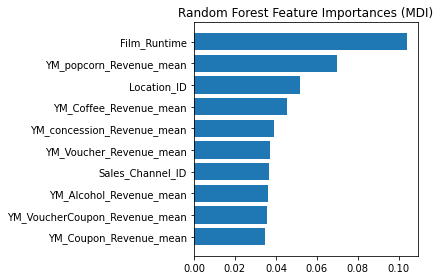

<Figure size 1008x576 with 0 Axes>

In [ ]:

sorted_idx = importance.argsort()
y_ticks = np.arange(0, len(X_train_f_1.columns)-22)
fig, ax = plt.subplots()
ax.barh(y_ticks, importance[sorted_idx][21:-1])
ax.set_yticklabels(X_train_f_1.columns[sorted_idx][21:-1])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
plt.figure(figsize=(14, 8));
fig.tight_layout()
plt.show()

In [ ]:
importance.sort()
importance

array([0.00179597, 0.00230235, 0.00239364, 0.00259499, 0.0026569 ,
       0.00269328, 0.00270456, 0.00275762, 0.00939408, 0.0099024 ,
       0.0104902 , 0.0105659 , 0.01059399, 0.0131537 , 0.01373777,
       0.01568197, 0.01653473, 0.01726864, 0.01766427, 0.02169422,
       0.021946  , 0.02352594, 0.02746021, 0.0283139 , 0.0306686 ,
       0.05023076, 0.05787402, 0.06858889, 0.07691571, 0.09788965,
       0.12148094, 0.20852417])

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', criterion='gini', random_state=0, n_estimators=250, max_depth=15)
clf.fit(X_train_All, y_train)
print_scores(clf,X_test_All,y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

F1 Score   = 0.766
Accuracy   = 0.838
Kappa      = 0.533
Log Loss   = 5.589

Confusion Matrix:
        pred:0  pred:1
true:0    3607     494
true:1     344     734

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4101
           1       0.60      0.68      0.64      1078

    accuracy                           0.84      5179
   macro avg       0.76      0.78      0.77      5179
weighted avg       0.85      0.84      0.84      5179



GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dis

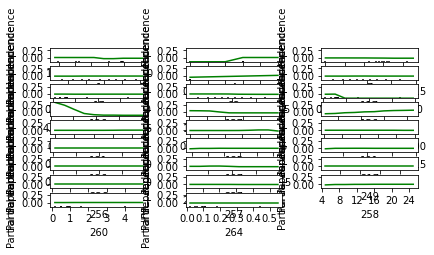

In [ ]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
X, y = X_train_All, y_train
clf = GradientBoostingRegressor()
clf.fit(X_train_All, y_train)
my_plots = plot_partial_dependence(clf, X=X_train_All,      
                                   features=feature_columns, grid_resolution=10) 


In [ ]:
X_train_f_1.head()

,Location_ID,Sales_Channel_ID,Film_Runtime,Visit_Date_Week,Sales_Channel_Breakdown_Sales_MainStore,YM_Alcohol_Revenue_mean,YM_Coffee_Revenue_min,YM_Coffee_Revenue_mean,YM_popcorn_Revenue_min,YM_popcorn_Revenue_mean,YM_popcorn_Points_Earned_mean,YM_concession_Revenue_mean,YM_concession_Spend_mean,YM_concession_Discount_mean,YM_concession_Points_Earned_sum,YM_Voucher_Revenue_min,YM_Voucher_Revenue_mean,YM_Coupon_Revenue_mean,YM_VoucherCoupon_Revenue_min,YM_VoucherCoupon_Revenue_mean,YM_VoucherCoupon_Points_Earned_mean,Ticket_Revenue_min,Ticket_Revenue_mean,Ticket_Revenue_max,Ticket_Spend_min,Ticket_Discount_min
0,7253,8,133.0000,0,1.0000,8.4242,6.4900,8.4242,7.5200,8.6000,75.0000,8.6000,8.6000,0.9545,825.0000,6.4900,8.4242,8.4242,6.4900,8.4242,71.4167,6.4900,6.4900,6.4900,6.4900,0.7200
1,7123,8,0.0000,0,1.0000,6.3078,0.4900,6.3474,0.5000,6.2870,63.1404,10.5942,7.0733,0.7867,750.0000,0.4900,6.3474,6.3128,0.4900,6.3128,59.5224,0.4900,5.4373,16.1900,0.4900,0.0500
2,7290,8,143.0000,0,1.0000,5.4635,0.8000,5.4635,0.8000,5.4339,34.0870,6.7114,4.4079,0.4886,625.0000,0.8000,5.4635,5.4635,0.8000,5.4635,34.8846,0.8000,3.5493,7.4900,0.8000,0.0900
3,1142,2,131.0000,0,0.0000,6.1032,0.5000,6.1032,0.5000,6.6671,23.8235,9.1433,2.1433,0.2367,250.0000,0.5000,6.1032,6.1032,0.5000,6.1032,23.1818,0.5000,3.9985,7.1900,0.5000,0.0600
4,9181,2,104.0000,0,0.0000,7.8424,0.7800,7.8424,0.7800,7.8424,88.1905,8.0289,8.0289,0.8906,1650.0000,0.7800,7.8424,7.8424,0.7800,7.8424,88.1905,0.7800,4.3460,7.9900,0.7800,0.0900


In [ ]:
plt.plot

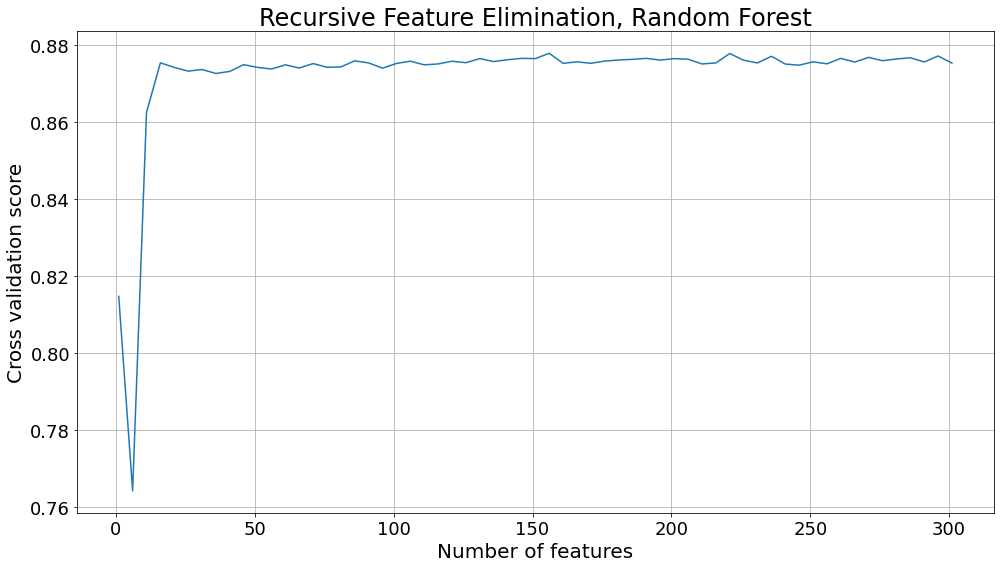

In [ ]:
import matplotlib.pyplot as plt
#print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(14, 8));
plt.grid(True);
plt.title('Recursive Feature Elimination, Random Forest', fontsize=24);
plt.xlabel("Number of features", fontsize=20);
plt.ylabel("Cross validation score", fontsize=20);
plt.plot(range(1, 5*(len(rfecv.grid_scores_)),5), rfecv.grid_scores_);
plt.xticks(fontsize=18,);
plt.yticks(fontsize=18);
plt.tight_layout();
#plt.savefig('out/german_credit-rfe.png');

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_f, y_train)

print_scores(clf,X_test_f,y_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

F1 Score   = 0.697
Accuracy   = 0.785
Kappa      = 0.395
Log Loss   = 7.423

Confusion Matrix:
        pred:0  pred:1
true:0    3432     669
true:1     444     634

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      4101
           1       0.49      0.59      0.53      1078

    accuracy                           0.79      5179
   macro avg       0.69      0.71      0.70      5179
weighted avg       0.80      0.79      0.79      5179



In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_f, y_train)

print_scores(clf,X_test_f,y_test)

NameError: ignored

In [ ]:
clf = RandomForestClassifier( class_weight='balanced', criterion='gini', random_state=42, n_estimators=200, max_depth=15)
clf.fit(X_train_f, y_train)

print_scores(clf,X_test_f,y_test)

NameError: ignored

In [ ]:
hyperparams = {"max_depth":sp_randint(10,20),
                 "max_leaf_nodes": sp_randint(10,20),
                 "criterion":["gini","entropy"]}

clf = RandomForestClassifier(n_estimators=200, class_weight={0:.4,1:.6})   
clf = RandomizedSearchCV(clf,param_distributions=hyperparams, cv=5, n_iter=100, return_train_score=True)
clf.fit(X_train_All, y_train)

print_scores(clf,X_test_All,y_test)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight={0: 0.4,
                                                                  1: 0.6},
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                   

F1 Score   = 0.731
Accuracy   = 0.840
Kappa      = 0.464
Log Loss   = 5.522

Confusion Matrix:
        pred:0  pred:1
true:0    3827     274
true:1     554     524

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4101
           1       0.66      0.49      0.56      1078

    accuracy                           0.84      5179
   macro avg       0.77      0.71      0.73      5179
weighted avg       0.83      0.84      0.83      5179



In [ ]:
hyperparams = {"max_depth":sp_randint(5,15),
                 "max_features":sp_randint(1,12),
                 "max_leaf_nodes": sp_randint(7,15),
                 "criterion":["gini","entropy"]}

clf = DecisionTreeClassifier()
clf = RandomizedSearchCV(clf,param_distributions=hyperparams, cv=5, n_iter=100, return_train_score=True)
clf.fit(X_train_All, y_train)

print_scores(clf,X_test_All,y_test)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

F1 Score   = 0.667
Accuracy   = 0.816
Kappa      = 0.342
Log Loss   = 6.369

Confusion Matrix:
        pred:0  pred:1
true:0    3843     258
true:1     697     381

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4101
           1       0.60      0.35      0.44      1078

    accuracy                           0.82      5179
   macro avg       0.72      0.65      0.67      5179
weighted avg       0.79      0.82      0.80      5179



In [ ]:

def decision_tree():
  clf = DecisionTreeClassifier(class_weight={0:.2,1:.8})
  rfecv = RFECV(estimator=clf, step=10, cv=StratifiedKFold(20), scoring='accuracy')
  sel = rfecv.fit(X_train_All,y_train)
  X_train_f = X_train_All.loc[:,sel.support_]
  X_test_f = X_test_All.loc[:,sel.support_]
  hyperparams = {"max_depth":sp_randint(5,15),
                 "max_features":sp_randint(1,12),
                 "max_leaf_nodes": sp_randint(7,15),
                 "criterion":["gini","entropy"]}

  clf = DecisionTreeClassifier(class_weight={0:.2,1:.8})
  clf = RandomizedSearchCV(clf,param_distributions=hyperparams, cv=5, n_iter=100, return_train_score=True)

  %time clf.fit(X_train_f,y_train) 
  print_scores(clf,X_train_f,y_train)
  print_scores(clf,X_test_f,y_test)

def random_forest():
  clf = RandomForestClassifier(n_estimators=200, class_weight={0:.4,1:.6})
  rfecv = RFECV(estimator=clf, step=5, cv=StratifiedKFold(20), scoring='accuracy')
  sel = rfecv.fit(X_train_All,y_train)
  X_train_f = X_train_All.loc[:,sel.support_]
  X_test_f = X_test_All.loc[:,sel.support_]
  hyperparams = {"max_depth":sp_randint(10,20),
                 "max_leaf_nodes": sp_randint(10,20),
                 "criterion":["gini","entropy"]}

  clf = RandomForestClassifier(n_estimators=200, class_weight={0:.4,1:.6})   
  clf = RandomizedSearchCV(clf,param_distributions=hyperparams, cv=5, n_iter=100, return_train_score=True)
  %time clf.fit(X_train_f,y_train) 
  print_scores(clf,X_train_f,y_train)
  print_scores(clf,X_test_f,y_test)  
  return (X_train_f)
def XGBoost():
  clf = XGBClassifier(n_estimators=50)
  rfecv = RFECV(estimator=clf, step=10, cv=StratifiedKFold(20), scoring='accuracy')
  sel = rfecv.fit(X_train_All,y_train)
  X_train_f = X_train_All.loc[:,sel.support_]
  X_test_f = X_test_All.loc[:,sel.support_]
  hyperparams = {"max_depth":sp_randint(5,15),
                 "booster": ["gbtree", "gblinear", "dart"]}
  clf = XGBClassifier(n_estimators=50)   
  clf = RandomizedSearchCV(clf,param_distributions=hyperparams, cv=5, n_iter=100, return_train_score=True)               
  %time clf.fit(X_train_f,y_train) 
  print_scores(clf,X_train_f,y_train)
  print_scores(clf,X_test_f,y_test)

def Logistic_Regression():
  clf = LogisticRegressionCV(cv=5)
  rfecv = RFECV(estimator=clf, step=10, cv=StratifiedKFold(20), scoring='accuracy')
  sel = rfecv.fit(X_train_All,y_train)
  X_train_f = X_train_All.loc[:,sel.support_]
  X_test_f = X_test_All.loc[:,sel.support_]
  clf = LogisticRegressionCV(cv=5) 
  %time clf.fit(X_train_f,y_train) 
  print_scores(clf,X_train_f,y_train)
  print_scores(clf,X_test_f,y_test)

In [ ]:
X_train_All.columns

Index(['CINEPLEX_D_Membership_ID', 'Location_ID', 'Auditorium_Experience_ID',
       'Seating_Experience_ID', 'Sales_Channel_ID',
       'Performance_Experience_ID', 'Performance_Type_ID', 'Film_Runtime',
       'Is_IMAX', 'Is_DBOX_Capable',
       ...
       'Ticket_Discount_max', 'Ticket_Discount_sum',
       'Ticket_Points_Earned_min', 'Ticket_Points_Earned_mean',
       'Ticket_Points_Earned_max', 'Ticket_Points_Earned_sum',
       'Ticket_Points_Redeemed_min', 'Ticket_Points_Redeemed_mean',
       'Ticket_Points_Redeemed_max', 'Ticket_Points_Redeemed_sum'],
      dtype='object', length=297)

In [ ]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_All.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_All.columns.values]
X_test_All.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_All.columns.values]

In [ ]:
clf = XGBClassifier(n_estimators=200)
clf.fit(X_train_f, y_train)

print_scores(clf,X_test_f,y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

F1 Score   = 0.744
Accuracy   = 0.853
Kappa      = 0.493
Log Loss   = 5.068

Confusion Matrix:
        pred:0  pred:1
true:0    3900     201
true:1     559     519

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4101
           1       0.72      0.48      0.58      1078

    accuracy                           0.85      5179
   macro avg       0.80      0.72      0.74      5179
weighted avg       0.84      0.85      0.84      5179



In [ ]:
#decision_tree()
random_forest()
#XGBoost()
#Logistic_Regression()

NameError: ignored

In [ ]:
decision_tree()

CPU times: user 28.1 s, sys: 83 ms, total: 28.2 s
Wall time: 28.2 s
F1 Score   = 0.737
Accuracy   = 0.818
Kappa      = 0.475
Log Loss   = 6.271

Confusion Matrix:
        pred:0  pred:1
true:0   21374    3605
true:1    2038    4062

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     24979
           1       0.53      0.67      0.59      6100

    accuracy                           0.82     31079
   macro avg       0.72      0.76      0.74     31079
weighted avg       0.84      0.82      0.83     31079

F1 Score   = 0.709
Accuracy   = 0.803
Kappa      = 0.418
Log Loss   = 6.796

Confusion Matrix:
        pred:0  pred:1
true:0    3555     546
true:1     473     605

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4101
           1       0.53      0.56      0.54      1078

    accuracy                           0.80      5179
   macro av